In [2]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import yaml
import os
from scipy.stats import logistic

import metagames.functional as mf

In [3]:
default_agent_config = {
    'num_parameters': 10,
    'initializer': 'scaled_normal',
    'loss': 'utility',
    'optimizer': 'grad',
    'learning_rate': 1e-1,
    'step_rate': 1,
    'num_players': 1,
    'n_freeze_player_at': float("inf")
}
agent_configs = [
    {
        'agent': 'sum',
    },
    {
        'agent': 'selfish',
    },
    {
        'agent': 'linear',
    },
    {
        'agent': 'nn',
    },
    {
        'name': 'LinearDefect',
        'agent': 'linear',
        'loss': 'defect',
    }
]

In [4]:
def plot_experiment_utilities(title, data):
    step_statistics = mf.data.experiment_step_statistics(data)

    ax = plt.gca()
    for player, player_stats in step_statistics.items():
        plt.plot(player_stats['utility']['mean'], label=player)

    ax.legend()
    ax.set_ylabel('Utility')
    ax.set_xlabel('Global Step')
    ax.set_title(title)


def save_data(data, exp_name):
    """Uses yaml to save data to file names [time]: exp_name in path data/yaml.
    Data: A list of dictionaries returned by run_experiment
    """
    start_time = datetime.datetime.fromtimestamp(data[0]['timestamp_start'])
    data_directory = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'data'))
    filename = str(start_time)[:-7] + ': ' + exp_name + '.yaml'
    # foldername = start_time + ': ' + hp.exp_group_name
    pathname = os.path.join(data_directory, 'yaml')
    os.makedirs(pathname, exist_ok=True)
    file_path = os.path.join(pathname, filename)
    file = open(file_path, 'w+')
    yaml.dump(data, file)




def get_multi_run_stats(data):
    """Calculates across players at final step and across experiment runs:
    -mean utility
    -mean grad norm
    -mean coop prob
    (Add mean coop prob of winning player?)

    Data: A list of dictionaries returned by run_experiment
    Returns: dict mapping from stat name to value.
    """
    all_runs = []
    overall_stats = {}
    for n_run in range(len(data)):
        final_step = data[n_run]['steps'][-1]['player_updates']
        all_runs.append({})
        all_runs[n_run]['means'] = {}
        all_runs[n_run]['final_utility'] = []
        all_runs[n_run]['final_grad_norm'] = []
        all_runs[n_run]['final_action_prob'] = []
        for player_num, player in enumerate(final_step):
            player = player[0]  # Player is a [{}]
            all_runs[n_run]['final_utility'].append(player['mean_utility'])
            all_runs[n_run]['final_grad_norm'].append(player['grad_norm'])
            all_runs[n_run]['final_action_prob'].append(logistic.cdf(player['rounds'][0]['action_logit']))
        utilities_over_players = [all_runs[n_run]['final_utility'][i] for i in range(len(final_step))]
        grad_norms_over_players = [all_runs[n_run]['final_grad_norm'][i] for i in range(len(final_step))]
        action_probs_over_players = [all_runs[n_run]['final_action_prob'][i] for i in range(len(final_step))]
        all_runs[n_run]['means']['utility'] = np.mean(utilities_over_players)
        all_runs[n_run]['means']['grad_norm'] = np.mean(grad_norms_over_players)
        all_runs[n_run]['means']['action_prob'] = np.mean(action_probs_over_players)
    overall_stats['mean_utility'] = np.mean([all_runs[i]['means']['utility'] for i in range(len(all_runs))])
    overall_stats['mean_grad_norm'] = np.mean([all_runs[i]['means']['grad_norm'] for i in range(len(all_runs))])
    overall_stats['mean_action_prob'] = np.mean([all_runs[i]['means']['action_prob'] for i in range(len(all_runs))])
    return overall_stats

NameError: name '__file__' is not defined

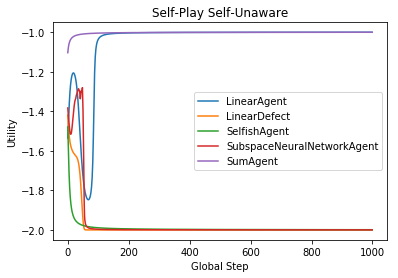

In [5]:
data_self_play = []
for n_run in range(1):
    data_self_play.append(mf.main.run_experiment(
        experiment='self_play_self_unaware',
        game='prisoners_dilemma',
        num_steps=1000,
        agents_config=agent_configs,
        default_agent_config=default_agent_config,
        agent_seed=n_run,
        parameter_seed=n_run,
    ))
    plot_experiment_utilities('Self-Play Self-Unaware', data_self_play[n_run])
    # plt.show()
save_data(data_self_play, 'Self-play Self-Unaware')
get_multi_run_stats(data_self_play)

In [5]:
duel_data = []
for n_run in range(1):
    duel_data.append(mf.main.run_experiment(
        experiment='duel',
        game='prisoners_dilemma',
        num_steps=1000,
        agents_config=[{'agent': 'linear', 'num_players': 2}],
        default_agent_config=default_agent_config,
        agent_seed=1,
        parameter_seed=2,
    ))
    plot_experiment_utilities('Duel', duel_data[n_run])
    # plt.show()
save_data(duel_data, 'Duel')
get_multi_run_stats(duel_data)

Elapsed Time: 0:00:03.986464


In [6]:
asymmetric_duel_data = []
for n_run in range(1):
    asymmetric_duel_data.append(mf.main.run_experiment(
        experiment='duel',
        game='prisoners_dilemma',
        num_steps=1000,
        agents_config=[
            {'agent': 'linear', 'num_parameters': 1, 'num_opponent_parameters': 20, 'name': 'small'},
            {'agent': 'linear', 'num_parameters': 20, 'num_opponent_parameters': 1, 'name': 'large'},
        ],
        default_agent_config=default_agent_config,
        agent_seed=n_run,
        parameter_seed=n_run+1,
    ))
    plot_experiment_utilities('Asymmetric Duel', asymmetric_duel_data[n_run])
    # plt.show()
save_data(asymmetric_duel_data, 'Asymmetric Duel')
get_multi_run_stats(asymmetric_duel_data)

In [1]:
# Assymetric Duel with freezing larger player
asymmetric_duel_data_freeze = []
for n_run in range(1):
    asymmetric_duel_data_freeze.append(mf.main.run_experiment(
        experiment='duel',
        game='prisoners_dilemma',
        num_steps=100,
        agents_config=[
            {'agent': 'linear', 'num_parameters': 1, 'num_opponent_parameters': 20, 'name': 'small'},
            {'agent': 'linear', 'num_parameters': 20, 'num_opponent_parameters': 1, 'name': 'large', 'n_freeze_player_at': 500},
        ],
        default_agent_config=default_agent_config,
        agent_seed=n_run,
        parameter_seed=n_run,
    ))
    plot_experiment_utilities('Asymmetric Duel', asymmetric_duel_data_freeze[n_run])
    # plt.show()
save_data(asymmetric_duel_data_freeze, 'Asymmetric Duel Freeze')
get_multi_run_stats(asymmetric_duel_data_freeze)

NameError: name 'mf' is not defined

In [8]:
free_for_all_data = []
for n_run in range(1):
    free_for_all_data.append(mf.main.run_experiment(
        experiment='free_for_all',
        game='prisoners_dilemma',
        num_steps=1000,
        agents_config=[
            {'agent': 'selfish'},
            {'agent': 'defect'},
            {'agent': 'cooperate'},
            {'agent': 'linear'},
            {'agent': 'nn', 'num_players': 2},
            {'agent': 'clique', 'num_players': 2}
        ],
        default_agent_config=default_agent_config,
        agent_seed=1,
        parameter_seed=2,
    ))
    plot_experiment_utilities('Free-for-all', free_for_all_data[n_run])
    # plt.show()
save_data(free_for_all_data, 'Free-for-all')
get_multi_run_stats(free_for_all_data)

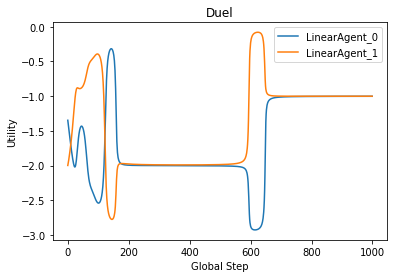

7


In [9]:
step_idx = 0         # Global step
player_idx = 0       # Player index (in list of all players data['players'])
player_step_idx = 0  # Player substep (may take multiple steps per global step)
round_idx = 0        # Substep gradient may be accumulated over multiple rounds with different opponents
free_for_all_data[0]['steps'][step_idx]['player_updates'][player_idx][player_step_idx]['rounds'][round_idx]

start_time = datetime.datetime.fromtimestamp(free_for_all_data[0]['timestamp_start'])
end_time = datetime.datetime.fromtimestamp(free_for_all_data[-1]['timestamp_end'])
print('Elapsed Time:', end_time - start_time)

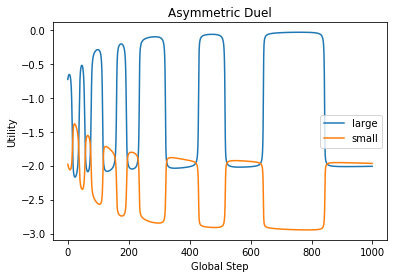

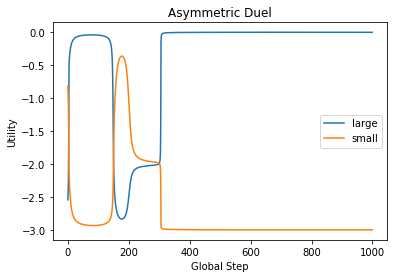

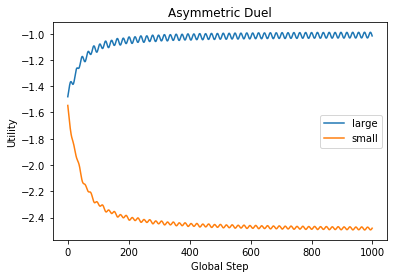

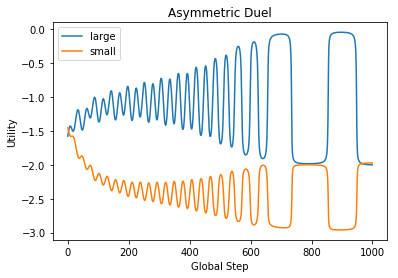

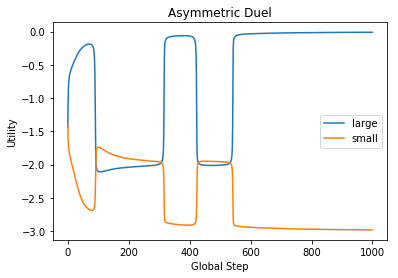

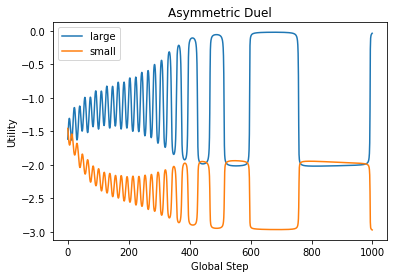

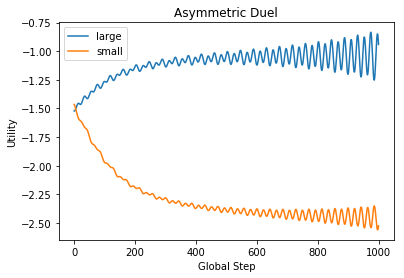

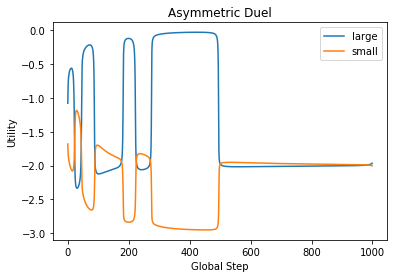

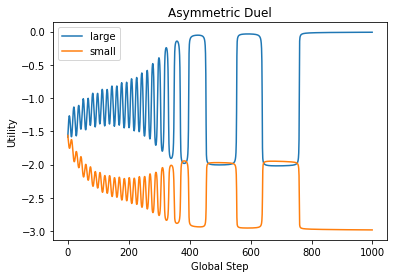

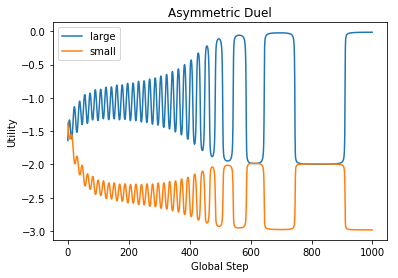

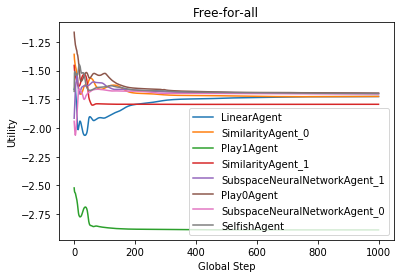